# Libraries

In [1]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import os
import pickle
import json
from   tqdm   import tqdm
import pandas as pd
import numpy  as np
import time


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot as plt
import seaborn           as sns


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow                 as tf
from   tensorflow.keras.callbacks import *
from   tensorflow.keras.metrics   import *
from   tensorflow.keras.layers    import *
from   tensorflow.keras           import Sequential
from   tensorflow.keras           import optimizers



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User libraries
#
from utils.Logger        import *
from utils.InfuxDBClient import *

# Parameters

In [2]:
# Selected sensor
#
Sensor = '01cc0529-79bb-48cc-a052-4fde9372abeb'

# Set look-back (Lag)
#
Lag = 32

# Set 'verbose'
#
VERBOSE = True

# Initiate logger
#
if VERBOSE:
    logger = init_logger( log_file = 'logs.log' )  

# Data

## Download data from InfuxDB

## Setup InfuxDB Client

In [3]:
influx_measurement = "beat_box_rms"


# Change to influx live data 
#
influx = InfluxDataframeDBClient(host     = '192.168.2.198', 
                                 username = 'admin',
                                 pwd      = 'CoreInn02019', 
                                 port     =  8086, 
                                 db       = 'corebeat_rms')
influx.initClient()

### Download data

In [4]:
# Start timer
#
start_timer = time.time()

# TABLE: corebeat_rms
#
df = influx.client.query(f'SELECT * from {influx_measurement}') 
df = df[ influx_measurement ]
#
if VERBOSE: 
    logger.info('[INFO] Download data from CoreBEAT database')
    logger.info('[INFO] Time: {:.2f}s'.format(time.time() - start_timer))



# Preprocess data
#
df = df[ df['beat_box_id'] == Sensor]

# 
del df['beat_box_id']


if VERBOSE: 
    logger.info('[INFO] Data cleaning - Data processing')
    logger.info('[INFO] Number of features: {}'.format(df.shape[1]))
    
df.head( 3 )

[INFO] Download data from CoreBEAT database
[INFO] Time: 1.46s
[INFO] Data cleaning - Data processing
[INFO] Number of features: 4


,acc_x,acc_y,acc_z,temperature
2022-06-18 02:01:19+00:00,0.238592,0.186857,0.211078,31.8
2022-06-18 02:02:19+00:00,0.186287,0.129006,0.146181,31.8
2022-06-18 02:03:18+00:00,0.187383,0.137613,0.151158,31.9


# Training/Validation/Testing datasets

## Split data

In [5]:
train_idx = int( df.shape[0] * 0.8 )
valid_idx = int( df.shape[0] * 0.9 )


df_train = df[ :train_idx ].copy()
df_valid = df[ train_idx:valid_idx ].copy()
df_test  = df[ valid_idx: ]

## Fix lag

In [6]:
df_valid = pd.concat([df_train.iloc[-Lag:], df_valid])
df_test  = pd.concat([df_valid.iloc[-Lag:], df_test])

## Scaling data

In [7]:
# Set scaler
#
scaler = StandardScaler()

df_train = pd.DataFrame(data    = scaler.fit_transform(df_train),
                        columns = df_train.columns, 
                        index   = df_train.index)

df_valid = pd.DataFrame(data    = scaler.transform(df_valid),
                        columns = df_valid.columns, 
                        index   = df_valid.index)


df_test   = pd.DataFrame(data    = scaler.transform(df_test),
                         columns = df_test.columns, 
                         index   = df_test.index)

# Creating training/validation/testing instances

In [8]:
def create_dataset(df = None, Lag = 1, overlap = 1):
    
    X, Dates = [], []
    for i in tqdm( range( df.shape[0] - Lag ) ):
        X     += [ df[i:i+Lag].to_numpy() ]
        Dates += [ df.index[i+Lag]        ]
    
    return ( np.array(X), np.array(Dates) )

In [9]:
# Training instances
#
trainX, trainDates = create_dataset(df = df_train, Lag = Lag)
if VERBOSE: 
    logger.info('[INFO] Training instances created')

    
# Validation instances
#
validX, validDates = create_dataset(df = df_valid, Lag = Lag)
if VERBOSE: 
    logger.info('[INFO] Validation instances created')
 

# Testing instances
#
testX, testDates   = create_dataset(df = df_test, Lag = Lag)
if VERBOSE: 
    logger.info('[INFO] Testing instances created')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22068/22068 [00:01<00:00, 21745.22it/s]
[INFO] Training instances created
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2763/2763 [00:00<00:00, 22138.71it/s]
[INFO] Validation instances created
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2763/2763 [00:00<00:00, 22228.65it/s]
[INFO] Testing instances created


# Anomaly detection model

## Setup CUDA

In [10]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        
    except RuntimeError as e:
        
        # Memory growth must be set before GPUs have been initialized
        print(e)

## Setup model

In [11]:
# Define metrics
#
metrics = [
            RootMeanSquaredError(name = 'RMSE', dtype = None),
            MeanAbsoluteError(name='MAE', dtype=None)
          ]

2022-07-07 14:48:12.203093: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
   
model = Sequential(
    [
        Input(shape = (trainX.shape[1], trainX.shape[2]), name = 'InputLayer'),
        #
        # Since the problem is semi-supervised - Gaussian noise is applied
        GaussianNoise( stddev = 0.05 ),
        
        # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
        # Encoder
        #
        Conv1D(filters     = 32, 
               kernel_size = 7, 
               padding     = "same", 
               strides     = 1, 
               activation  = "elu"),
        #
        BatchNormalization(),
        Dropout(0.5),
        #
        MaxPooling1D(pool_size = 2, 
                     padding   = 'same'),
        #
        Conv1D(filters     = 16, 
               kernel_size = 3, 
               padding     = "same", 
               strides     = 1, 
               activation  = "elu"),
        #
        BatchNormalization(),
        Dropout(0.2),
        #        
        MaxPooling1D(2, padding='same'),
        
        
        # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
        # Decoder
        #
        Conv1D(filters     = 16, 
               kernel_size = 3, 
               padding     = "same", 
               strides     = 1, 
               activation  = "elu"),
        #
        BatchNormalization(),
        #
        UpSampling1D(size = 2),
        #
        Conv1D(filters     = 32, 
               kernel_size = 7, 
               padding     = "same", 
               strides     = 1, 
               activation  = "elu"),
        #
        BatchNormalization(),
        #
        UpSampling1D(size = 2),
        #
        Conv1D(filters     = trainX.shape[2], 
               kernel_size = 3, 
               padding     = "same", 
               strides     = 1, 
               activation  = "linear",
               name        = 'OutputLayer' ),        
    ]
)



# Set loss and optimizer
#
model.compile(optimizer = optimizers.Adam(learning_rate = 1e-4),
              loss      = 'mse',
              metrics   = metrics)

if VERBOSE:
    logger.info('[INFO] Anomaly detection model was setup')

[INFO] Anomaly detection model was setup


In [13]:
print('[INFO] Input layer:  ', model.input.name)
print('[INFO] Output layer: ', model.output.name)

# Model summary
#
model.summary()

[INFO] Input layer:   InputLayer
[INFO] Output layer:  OutputLayer/BiasAdd:0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 32, 4)            0         
 se)                                                             
                                                                 
 conv1d (Conv1D)             (None, 32, 32)            928       
                                                                 
 batch_normalization (BatchN  (None, 32, 32)           128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 32)           0         
 )                                           

## Setup training parameters

In [14]:
# Set parameters
#
parameters = {'epochs'           : 1000,
              'batch_size'       : 64,
              'verbose'          : True}




# Checkpoint
#
if ( not os.path.isdir('checkpoint') ):
    os.mkdir('checkpoint')
#
checkpoint = ModelCheckpoint("checkpoint/AnomalyDetectionModel.hdf5", 
                             save_weights_only = True,
                             monitor           = 'val_loss', 
                             verbose           = 0, 
                             save_best_only    = True, 
                             mode              = 'min')

# Earlystopping
#
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 20)


# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor   = 'val_loss', 
                                   factor    = 0.5,
                                   min_delta = 1.e-6,
                                   patience  = 10)


if VERBOSE:
    logger.info('[INFO] Training process was setup')

[INFO] Training process was setup


## Model training

In [15]:
start_timer = time.time()

score = model.fit(trainX, trainX,
                  epochs           = parameters['epochs'],
                  batch_size       = parameters['batch_size'],                    
                  verbose          = parameters['verbose'],
                  #
                  callbacks        = [checkpoint, earlystopping, lrs_scheduler],
                  #
                  validation_data  = (validX, validX))

if VERBOSE:
    logger.info('[INFO] Model has been successfully trained')
    logger.info('[INFO ] Time: {:.2f}s'.format(time.time() - start_timer))

Epoch 1/1000
345/345 [==============================] - 3s 5ms/step - loss: 0.9493 - RMSE: 0.9743 - MAE: 0.6910 - val_loss: 0.4095 - val_RMSE: 0.6399 - val_MAE: 0.4000 - lr: 1.0000e-04
Epoch 2/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.4563 - RMSE: 0.6755 - MAE: 0.4623 - val_loss: 0.3647 - val_RMSE: 0.6039 - val_MAE: 0.3596 - lr: 1.0000e-04
Epoch 3/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.3961 - RMSE: 0.6293 - MAE: 0.4206 - val_loss: 0.3443 - val_RMSE: 0.5868 - val_MAE: 0.3420 - lr: 1.0000e-04
Epoch 4/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.3688 - RMSE: 0.6073 - MAE: 0.4023 - val_loss: 0.3282 - val_RMSE: 0.5728 - val_MAE: 0.3335 - lr: 1.0000e-04
Epoch 5/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.3505 - RMSE: 0.5920 - MAE: 0.3900 - val_loss: 0.3174 - val_RMSE: 0.5634 - val_MAE: 0.3242 - lr: 1.0000e-04
Epoch 6/1000
345/345 [==============================] - 2s 5ms/step - loss:

345/345 [==============================] - 2s 5ms/step - loss: 0.1577 - RMSE: 0.3971 - MAE: 0.2716 - val_loss: 0.1271 - val_RMSE: 0.3566 - val_MAE: 0.2213 - lr: 1.0000e-04
Epoch 46/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1572 - RMSE: 0.3965 - MAE: 0.2712 - val_loss: 0.1310 - val_RMSE: 0.3620 - val_MAE: 0.2281 - lr: 1.0000e-04
Epoch 47/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1562 - RMSE: 0.3952 - MAE: 0.2695 - val_loss: 0.1286 - val_RMSE: 0.3586 - val_MAE: 0.2233 - lr: 1.0000e-04
Epoch 48/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1556 - RMSE: 0.3945 - MAE: 0.2699 - val_loss: 0.1274 - val_RMSE: 0.3569 - val_MAE: 0.2258 - lr: 1.0000e-04
Epoch 49/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1541 - RMSE: 0.3925 - MAE: 0.2683 - val_loss: 0.1269 - val_RMSE: 0.3563 - val_MAE: 0.2207 - lr: 1.0000e-04
Epoch 50/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1539 

345/345 [==============================] - 2s 5ms/step - loss: 0.1402 - RMSE: 0.3744 - MAE: 0.2556 - val_loss: 0.1210 - val_RMSE: 0.3479 - val_MAE: 0.2116 - lr: 5.0000e-05
Epoch 90/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1415 - RMSE: 0.3762 - MAE: 0.2569 - val_loss: 0.1199 - val_RMSE: 0.3463 - val_MAE: 0.2131 - lr: 5.0000e-05
Epoch 91/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1396 - RMSE: 0.3736 - MAE: 0.2550 - val_loss: 0.1192 - val_RMSE: 0.3452 - val_MAE: 0.2118 - lr: 5.0000e-05
Epoch 92/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1400 - RMSE: 0.3741 - MAE: 0.2556 - val_loss: 0.1141 - val_RMSE: 0.3377 - val_MAE: 0.2102 - lr: 5.0000e-05
Epoch 93/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1397 - RMSE: 0.3737 - MAE: 0.2550 - val_loss: 0.1201 - val_RMSE: 0.3465 - val_MAE: 0.2126 - lr: 5.0000e-05
Epoch 94/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1393 

[INFO] Model has been successfully trained
[INFO ] Time: 201.64s


Epoch 00112: early stopping


### Training progress

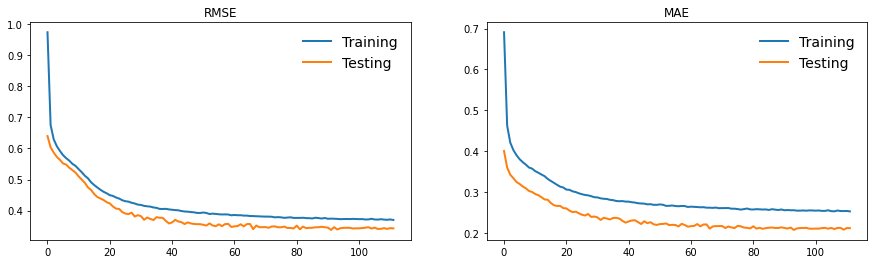

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4) )

ax[0].plot( score.history['RMSE'],     linewidth = 2 )
ax[0].plot( score.history['val_RMSE'], linewidth = 2 )
ax[0].legend(['Training', 'Testing'], frameon = False, fontsize = 14)
ax[0].set_title('RMSE');


ax[1].plot( score.history['MAE'],     linewidth = 2 )
ax[1].plot( score.history['val_MAE'], linewidth = 2 )
ax[1].legend(['Training', 'Testing'], frameon = False, fontsize = 14)
ax[1].set_title('MAE');

### Load optimized model

In [17]:
model.load_weights( 'checkpoint/AnomalyDetectionModel.hdf5' )

# Evaluation

## Evaluation on Training data 

In [18]:
# Get predictions
#
pred = model.predict( trainX )


# Calculate Loss (MSE)
#
train_loss = np.mean( np.mean((pred - trainX)**2, axis = 2), axis = 1)


# Create DataFrame with results (loss)
#
Train_Loss = pd.DataFrame( {'Date'  : trainDates,
                            'Loss'  : train_loss,
                           })

Train_Loss.set_index('Date', inplace=True)

In [19]:
# Get predictions
#
pred = model.predict( validX )


# Calculate Loss (MSE)
#
valid_loss = np.mean( np.mean((pred - validX)**2, axis = 2), axis = 1)


# Create DataFrame with results (loss)
#
Valid_Loss = pd.DataFrame( {'Date'   : validDates,
                            'Loss'   : valid_loss,
                           })

Valid_Loss.set_index('Date', inplace=True)

## Define thresholds

In [20]:
# Calculate thresholds
#
WARNING  = np.quantile( Train_Loss['Loss'], 0.95 )
CRITICAL = np.quantile( Train_Loss['Loss'], 0.997 )

logger.info('[INFO] Threshold were calculated')
#
print('[INFO] WARNING  threshold: ', WARNING)
print('[INFO] CRITICAL threshold: ', CRITICAL)

[INFO] Threshold were calculated


[INFO] WARNING  threshold:  0.36632218745310674
[INFO] CRITICAL threshold:  1.360080607654051


## Visualization

### Loss Histogram

/Users/livieris/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/livieris/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


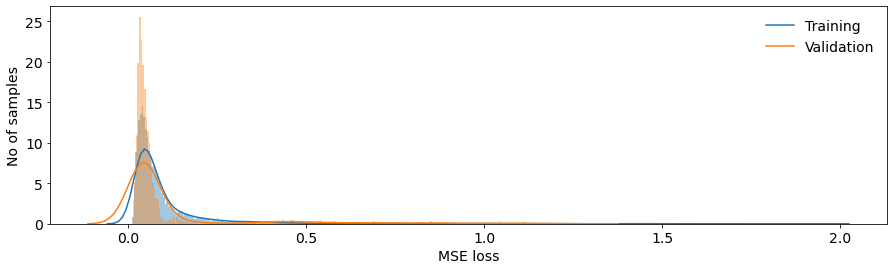

In [21]:
fig, ax = plt.subplots( figsize = (15, 4) )

sns.distplot(Train_Loss['Loss'], bins = 'auto', kde = True, ax = ax)
sns.distplot(Valid_Loss['Loss'], bins = 'auto', kde = True, ax = ax)

plt.legend(['Training', 'Validation'], frameon = False, fontsize = 14)
plt.xticks( size = 14 )
plt.yticks( size = 14 )
plt.xlabel("MSE loss", size=14)
plt.ylabel("No of samples", size=14)
plt.show()

### Plot Train/Valid loss

Number of anomaly samples:  67/22068


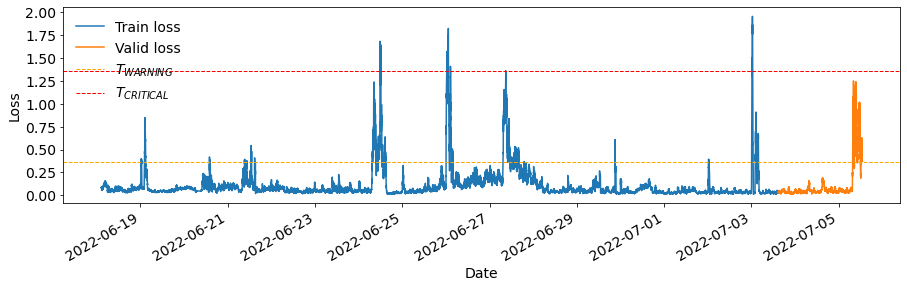

In [22]:
# Detect all the samples which are anomalies
#
anomalies = Train_Loss['Loss'] > CRITICAL
#
Train_Loss['anomaly'] = np.where(anomalies, 'ANOMALY', 'NORMAL')


print("Number of anomaly samples:  {}/{}".format(np.sum(anomalies), len(anomalies)) )


# Plot train-loss
#
ax = Train_Loss.plot( figsize = (15, 4) )
# Plot valid-loss
Valid_Loss.plot(ax = ax)


# Plot thresholds
#
plt.axhline(y=WARNING,  linewidth=1, color='orange', linestyle='--')
plt.axhline(y=CRITICAL, linewidth=1, color='red',    linestyle='--')


plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel("Date", size = 14)
plt.ylabel("Loss", size = 14);
plt.legend(['Train loss', 'Valid loss', '$T_{WARNING}$', '$T_{CRITICAL}$'], frameon = False, fontsize = 14);
plt.show();

## Evaluation of Testing data

In [23]:
# Get predictions
#
pred = model.predict( testX )


# Calculate Loss (MSE)
#
test_loss = np.mean( np.mean((pred - testX)**2, axis = 2), axis = 1)


# Create DataFrame with results (loss)
#
Test_Loss = pd.DataFrame( {'Date' : testDates,
                           'Loss' : test_loss,
                           })


Test_Loss.set_index('Date', inplace=True)

## Visualization

### Loss Histogram

/Users/livieris/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/livieris/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


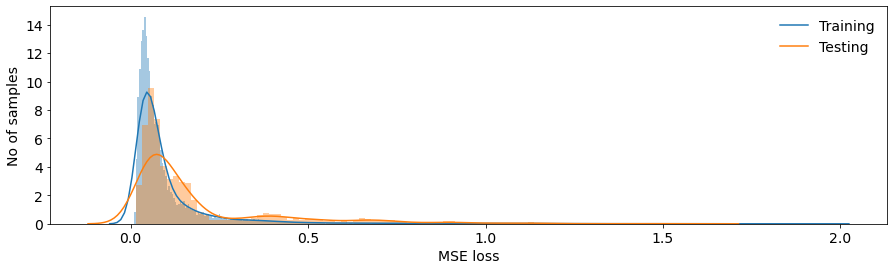

In [24]:
fig, ax = plt.subplots( figsize=(15, 4) )

sns.distplot(Train_Loss['Loss'], bins = 'auto', kde = True, ax = ax)
sns.distplot(Test_Loss['Loss'],  bins = 'auto', kde = True, ax = ax)

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.xticks( size = 14 )
plt.yticks( size = 14 )
plt.xlabel("MSE loss", size = 14)
plt.ylabel("No of samples", size = 14)
plt.show()

### Plot Train/Valid loss

Number of anomaly samples:  6/2763


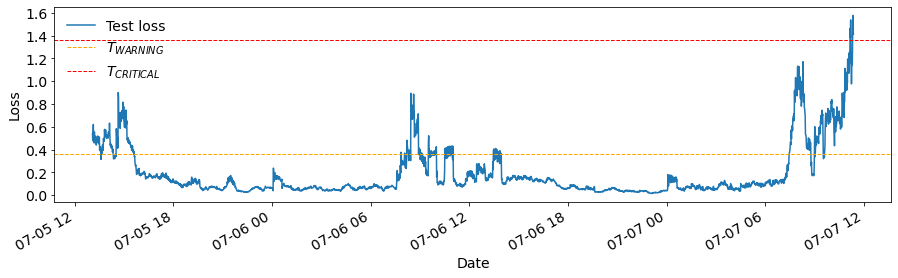

In [25]:
# Detect all the samples which are anomalies
#
anomalies = Test_Loss['Loss'] > CRITICAL
#
Test_Loss['anomaly'] = np.where(anomalies, 'ANOMALY', 'NORMAL')


print("Number of anomaly samples:  {}/{}".format(np.sum(anomalies), len(anomalies)) )


# Plot test-loss
#
ax = Test_Loss.plot( figsize = (15, 4) )


# Plot thresholds
#
plt.axhline(y=WARNING,  linewidth=1, color='orange', linestyle='--')
plt.axhline(y=CRITICAL, linewidth=1, color='red',    linestyle='--')


plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel("Date", size = 14)
plt.ylabel("Loss", size = 14);
plt.legend(['Test loss', '$T_{WARNING}$', '$T_{CRITICAL}$'], frameon = False, fontsize = 14);
plt.show();

# Save

In [26]:
# Save model
#
model.save( 'model_repository/AnomalyDetectionModel/1/model.savedmodel')
#
logger.info('[INFO] Anomaly detection model was saved in model_repository')

Function `_wrapped_model` contains input name(s) InputLayer with unsupported characters which will be renamed to inputlayer in the SavedModel.
2022-07-07 14:51:38.895409: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_repository/AnomalyDetectionModel/1/model.savedmodel/assets


Assets written to: model_repository/AnomalyDetectionModel/1/model.savedmodel/assets
[INFO] Anomaly detection model was saved in model_repository


In [27]:
# Save scaler
#
pickle.dump(scaler, open('model_repository/AnomalyDetectionModel/Scaler.pkl', 'wb'))

logger.info('[INFO] Scaler was saved in model_repository')

[INFO] Scaler was saved in model_repository


In [28]:
# Save thresholds
#
import json

Thresholds = {'WARNING':  WARNING,
              'CRITICAL': CRITICAL}

with open('model_repository/AnomalyDetectionModel/Thresholds.json', 'w') as fp:
    json.dump(Thresholds, fp)
#
logger.info('[INFO] Thresholds were saved in model_repository')

[INFO] Thresholds were saved in model_repository
